In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

# import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

[gpu(id=0)]

# Payoff

In [3]:
class EuropeanPayoff:

    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

# Smoothing

## test sequence

31.60696125855624


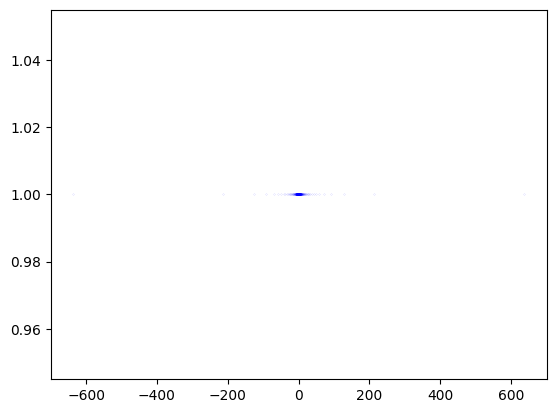

In [4]:
def chebyshev_sequence(n):
    # Generate Chebyshev nodes in the interval [-1, 1]
    k = np.arange(1, n + 1)
    nodes = np.tan((2 * k - 1) * np.pi / (2 * n))
    return nodes

# Number of points in the sequence
n = 1000  # Adjust as needed

# Generate the Chebyshev sequence
sequence = chebyshev_sequence(n)
print(jnp.std(sequence))
plt.plot(sequence, jnp.ones(n), 'b.', markersize=0.1)
plt.show()

In [5]:

def plot_smoothing(xs, ys, dys):
    plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
    plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
    plt.legend()
    plt.xlim([-1e0, 1e0])
    plt.ylim([-0.1, 1])
    plt.show()

## sigmoidal smoothing

0.001001001001001034


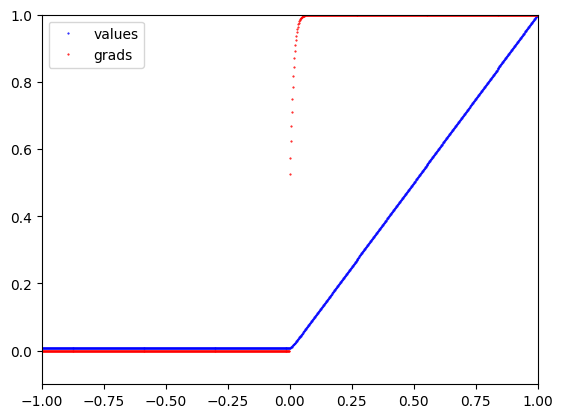

In [6]:
jax.clear_caches()
def sigmoidal_smoothing(f, k=100.0):

    def smooth_f(*args):
        return 1.0/k * jnp.log(1.0 + jnp.exp(k * f(*args)))

    return smooth_f

smooth_max = sigmoidal_smoothing(lambda x: jnp.maximum(0.0, x))

# xs = sequence
xs = jnp.linspace(-1, 1, 1000)
print(jnp.min(jnp.abs(xs)))
ys_true = jnp.maximum(0.0, xs)
# print("xs", xs)
# print("ys_true", ys_true)

ys, dys = jax.vmap(jax.value_and_grad(smooth_max))(xs)
plot_smoothing(xs, ys, dys)


## cubic spline smoothing

ys_error 9.375e-05


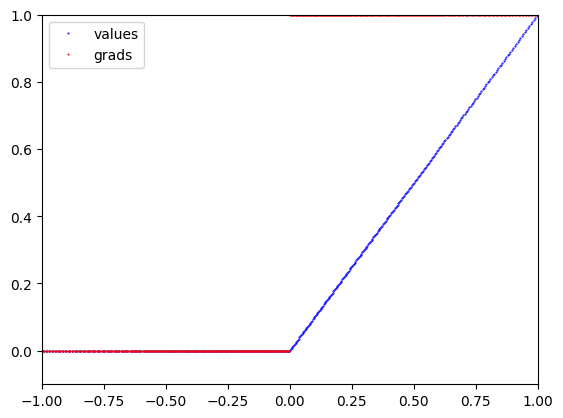

ys_error 0.00010556249999999998


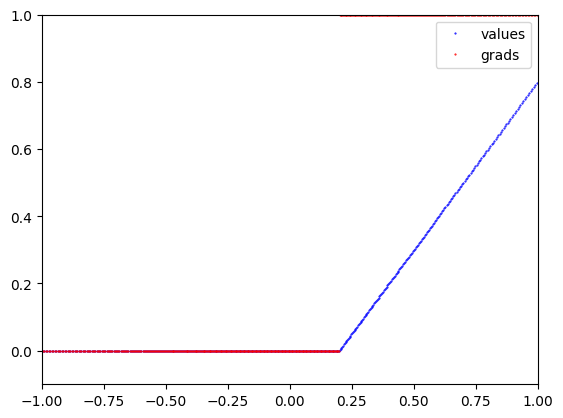

In [7]:
# cubic spline smoothing from:
# https://link.springer.com/article/10.1007/s00780-009-0097-9

def cubic_spline_smoothing(f, k=1e-3):
    @jit
    def smooth_f(*args):
        x = f(*args)
        i = jnp.argwhere(jnp.array([x < -k, x <= k, True]), size=1).squeeze()
        below = lambda x: jnp.zeros_like(x)
        poly = lambda x: -1/(16*(k**3)) * x**4 + 3/(8*k) * x**2 + .5*x + (3*k)/16
        above = lambda x: x
        return jax.lax.switch(i, [below, poly, above], x)

    return smooth_f

smooth_max_cubic = cubic_spline_smoothing(partial(jnp.maximum, 0.0))

xs = sequence
ys_true = jnp.maximum(0.0, xs)
ys, dys = jax.vmap(jax.value_and_grad(smooth_max_cubic))(xs)

print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)


euro_payoff = partial(EuropeanPayoff.call, strike_prices=.2)
euro_smooth = cubic_spline_smoothing(euro_payoff)
ys_true = euro_payoff(xs)
ys, dys = vmap(jax.value_and_grad(euro_smooth))(xs)
print("ys_error", jnp.mean(ys-ys_true))
plot_smoothing(xs, ys, dys)


# Checkpointing of scan

In [8]:
# Copyright 2022 Google LLC.
# SPDX-License-Identifier: Apache-2.0
# from: https://github.com/google/jax/issues/2139#issuecomment-1189382794
import math
import typing
from typing import Any, Callable, Optional, Sequence, Tuple, TypeVar, Union

import jax
import jax.numpy as jnp


Carry = TypeVar('Carry')
Input = TypeVar('Input')
Output = TypeVar('Output')
Func = TypeVar('Func', bound=Callable)


def nested_checkpoint_scan(
    f: Callable[[Carry, Input], Tuple[Carry, Output]],
    init: Carry,
    xs: Input,
    length: Optional[int] = None,
    *,
    nested_lengths: Sequence[int],
    scan_fn = jax.lax.scan,
    checkpoint_fn: Callable[[Func], Func] = jax.checkpoint,
) -> Tuple[Carry, Output]:
  """A version of lax.scan that supports recursive gradient checkpointing.

  The interface of `nested_checkpoint_scan` exactly matches lax.scan, except for
  the required `nested_lengths` argument.

  The key feature of `nested_checkpoint_scan` is that gradient calculations
  require O(max(nested_lengths)) memory, vs O(prod(nested_lengths)) for unnested
  scans, which it achieves by re-evaluating the forward pass
  `len(nested_lengths) - 1` times.

  `nested_checkpoint_scan` reduces to `lax.scan` when `nested_lengths` has a
  single element.

  Args:
    f: function to scan over.
    init: initial value.
    xs: scanned over values.
    length: leading length of all dimensions
    nested_lengths: required list of lengths to scan over for each level of
      checkpointing. The product of nested_lengths must match length (if
      provided) and the size of the leading axis for all arrays in ``xs``.
    scan_fn: function matching the API of lax.scan
    checkpoint_fn: function matching the API of jax.checkpoint.

  Returns:
    Carry and output values.
  """
  if length is not None and length != math.prod(nested_lengths):
    raise ValueError(f'inconsistent {length=} and {nested_lengths=}')

  def nested_reshape(x):
    x = jnp.asarray(x)
    new_shape = tuple(nested_lengths) + x.shape[1:]
    return x.reshape(new_shape)

  sub_xs = jax.tree_map(nested_reshape, xs)
  return _inner_nested_scan(f, init, sub_xs, nested_lengths, scan_fn,
                            checkpoint_fn)


def _inner_nested_scan(f, init, xs, lengths, scan_fn, checkpoint_fn):
  """Recursively applied scan function."""
  if len(lengths) == 1:
    return scan_fn(f, init, xs, lengths[0])

  @checkpoint_fn
  def sub_scans(carry, xs):
    return _inner_nested_scan(f, carry, xs, lengths[1:], scan_fn, checkpoint_fn)

  carry, out = scan_fn(sub_scans, init, xs, lengths[0])
  stacked_out = jax.tree_map(jnp.concatenate, out)
  return carry, stacked_out

# Heston

In [132]:
class ModelState(eqx.Module):
    S0: float
    v0: float
    
class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    # the state of the model at any given 
    class State(eqx.Module):
        S0: float
        v0: float
        
    # European call option price is at 34.99 for the following config: 
    class Parameters(eqx.Module):
        K: float = 100.0        # Strike price
        r: float = 0.05         # Risk-free rate
        T: float = 5.0          # n years until expiry, i.e. T2 - T1
        rho: float = -0.3       # Correlation of asset and volatility
        kappa: float = 2.00     # Mean-reversion rate
        theta: float = 0.09     # Long run average volatility
        xi: float = 1.00        # Volatility of volatility
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    v0: float = 0.09        # Initial volatility

    @classmethod
    def from_parameters(cls, parameters: Parameters, **kwargs):
        return cls(*astuple(parameters), **kwargs)
    # def __init__(self, S0, v0, params: HestonParams = HestonParams()):
    #     self.S0 = S0
    #     self.v0 = v0
    #     self.K = params.K
    #     self.r = params.r
    #     self.T = params.T
    #     self.rho = params.rho
    #     self.kappa = params.kappa
    #     self.theta = params.theta
    #     self.xi = params.xi
    
    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)

def volatility_path(v0, vol_draws, self):
    n_steps = len(vol_draws)
    dt = self.T / n_steps

    def vol_path_iter(prev_vol_path, vol_draw):
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_steps)
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path

def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_steps = len(spot_draws)
    dt = self.T / n_steps

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        v_truncated = smooth_max_cubic(vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_steps)
    # jax.debug.print("spot paths: {}", spot_paths)
    
    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def model_state_path(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    return s_path


def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    smooth_payoff_fn = cubic_spline_smoothing(payoff_fn)
    # smooth_payoff_fn = payoff_fn
    payoff = smooth_payoff_fn(spot_maturity, self.K)
    return payoff

def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    return payoff(self, model_state_path(state, self, vol_draws, spot_draws))

@eqx.filter_jit
def correlated_draws(self: Heston, key, n_samples: int):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])
    
    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))
    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws

def path_fn(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    # jax.debug.print("hest spots: {}", self.S0.shape)
    # jax.debug.print("hest vols: {}", self.v0.shape)
    # jax.debug.print("corr draws key: {}", key.shape)
    # jax.debug.print("hest time: {}", self.T)
    # n_time_steps = jnp.asarray(self.T * n_time_steps_per_year, int)
    # n_time_steps = self.T * n_time_steps_per_year
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self.model_state, self, vol_draws, spot_draws)

def differential_path(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1024):
    # n_time_steps = self.T * n_time_steps_per_year
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    p, dp = jax.value_and_grad(path_and_payoff)(self.model_state, self, vol_draws, spot_draws)
    return p, dp


In [133]:
@jax.jit
def f_long(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = jnp.maximum(0.0, prev_vol_path) # TODO: Needs smoothing!
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    #carry, vol_path = nested_checkpoint_scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter, nested_lengths=[1000, n_iter // 1000])
    
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path

In [124]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  K=100.0,
  r=0.05,
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0,
  S0=f64[100],
  v0=f64[100]
)


# Skip


In [97]:
def heston_taker(h: Heston):
    rng = jrandom.PRNGKey(0)
    return path_fn(h, rng)

In [98]:
res = eqx.filter_vmap(heston_taker)(h)
print(res.shape)

(100,)


In [99]:
if 0:
    key, subkey = jrandom.split(key)
    n_sims = 100
    
    keys = jrandom.split(subkey, n_sims)
    # keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    print(len(keys))
    print(keys.shape)
    
    # res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    # payoffs = eqx.filter_vmap(path_fn)(h, keys)
    
    #payoffs = jax.vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))#(h, keys)
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    # payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    
    print(payoffs)
    
    # payoffs(h, keys)
    
    # option_price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    # print(option_price.shape)
    # print(option_price)


In [100]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

@jit
def option_price(h, keys):
    return jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)

def inner(h, k):
    res =  eqx.filter_vmap(path_fn)(h, k)
    print(res.shape)
    return res

#payoffs = jit(eqx.filter_vmap(partial(inner, h)))(keys) 
# res = option_price(h, keys)
payoffs = jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)
print(payoffs.shape)

# print(jnp.mean(res, axis=))
res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)


100
(100, 100, 2)
(100, 100)
(100,)
[54.09734413  9.75479436 62.64859947 29.99281483  8.56348199 10.55571252
 15.1966848  20.54331406  8.52721969 53.90482487 22.31256732  8.95870446
 27.79338498 81.7844918  53.90030168 26.1059223  55.74843264 10.0031142
  6.32392609 30.15126222  4.25096498 24.42849241 93.68040873  4.9801091
 71.51061098 40.07787274 59.0955905  77.88646626 42.81899062  5.01805482
 45.98600872 42.3303256  80.16976251 12.03146963 62.67801414 79.83699636
 23.56395968 73.56687392 14.09202168 34.43198815 76.80392989 30.85259201
 46.52910114 17.03541833 85.27470694 22.11362214 14.49970996 26.55510382
 30.00865229 74.14693836 18.13724976  6.72523304 26.95479273 61.54556263
 23.76643088 46.08425932 54.6978506  11.24465609  8.52645403 42.63302379
 27.16767303 69.09260577 44.60736863 56.48508901 76.25169515  8.99279532
 60.01573521 12.1311611  47.20663752 60.96332349 54.28369447 28.82236961
 41.0932117  85.14353671 20.66872962 10.1281026  14.80294457 36.68516163
 50.35827219 76.0

# Skip End

In [101]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  K=100.0,
  r=0.05,
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0,
  S0=f64[100],
  v0=f64[100]
)


In [102]:
# the keys should be vmaped over in the inner loop

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
# print(keys.shape)

@eqx.filter_jit
def inner(h, k, n_paths=1024):

    # jax.debug.print("k.shape {}", k.shape)
    keys = jrandom.split(k, n_paths)
    res_fn = eqx.filter_vmap(path_fn, in_axes=(None, 0))
    # res = res_fn(h, keys)
    # print("inner: ", res.shape)
    res = jnp.sum(res_fn(h, keys))
    return res

print(inner)

@eqx.filter_jit
def option_price(key, h: Heston, n_paths=128):
    print(n_paths)
    payoffs_fn = eqx.filter_vmap(partial(inner, n_paths=n_paths))
    
    keys = jrandom.split(key, n_samples)
    # payoffs = payoffs_fn(h, keys) 
    price = jnp.divide(payoffs_fn(h, keys), n_paths) * jnp.exp(-h.r * h.T)
    return price
    # print(option_price)


# payoffs = eqx.filter_vmap(inner)(h, keys)

# res = option_price(h, keys)
# payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(x, keys))(h)
# print(payoffs.shape)
# print(payoffs)

# res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(res.shape)
# print(res)

_JitWrapper(
  _signature=<Signature (h, k, n_paths=1024)>,
  _dynamic_fun=(None,),
  _static_fun=((<function inner>,), PyTreeDef(*)),
  _cached=<wrapped function inner>,
  _filter_warning=False
)


In [103]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price(subkey, h)
print(p)


128
[39.44227693 14.91529254 60.89367524 26.92985062  7.86864063 11.47185016
 23.20080842 17.64367125  7.41195578 72.38349279 21.64402625  5.62423204
 24.65130261 96.70169276 43.50546307 15.24092245 63.96657443 13.83197017
 10.27297143 35.63982301  5.4937945  19.27956367 87.28612236  8.28314702
 59.08539206 48.97756037 54.19134037 67.58479931 26.35025053  5.87417232
 41.85931115 50.8498384  82.07134695 15.13722294 64.23058718 68.77780398
 32.20921472 69.92094461 19.49473516 40.14079721 66.31581753 24.14551378
 58.15570532 15.78694563 83.9896818  23.13275248 14.24551301 34.49535337
 36.05953588 65.05350606 17.39808541  5.53918277 25.58281516 45.77870278
 23.90065726 46.24712703 53.39570531 11.77201569  4.33898897 60.59202007
 30.19315094 76.41233845 49.02244518 46.72021937 65.42227498  9.69985558
 50.17403043 17.47716078 63.98333301 70.87652098 50.58493082 30.77906414
 50.99182798 73.36409455 22.56174222  9.61049095 20.54508339 48.01501297
 57.62419915 65.88244074 36.07919579 61.2861061

In [104]:

@eqx.filter_jit
def option_price2(key, h: Heston, n_sims=100):
    n_samples = h.S0.shape[0]
    # print(n_samples)
    keys = jrandom.split(key, n_sims)
    keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    return price

def price(key, heston: Heston):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price




@eqx.filter_jit
def option_price_scalar_chunked(h: Heston, key, n_paths=100000):

    def chunk_fn(h, keys):
        payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
        
    
    
    keys = jrandom.split(key, n_paths)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price
    
@eqx.filter_jit
def option_price_scalar(h: Heston, key, n_paths=100000):
    keys = jrandom.split(key, n_paths)
    payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price

def option_greeks_scalar(h: Heston, key, n_paths=10000):
    price, greeks = eqx.filter_value_and_grad(option_price_scalar)(h, key, n_paths)
    return price, greeks


def option_second_order_greeks_scalar(h: Heston, key, n_paths=10000):
    # (price, greeks), snd_greeks = eqx.filter_value_and_grad(eqx.filter_value_and_grad(option_price_scalar))(h, key, n_paths)
    res = jax.hessian(option_price_scalar)(h, key, n_paths)
    return res

def option_snd_order_jvp(h: Heston, key, n_paths = 1000):

    tangents = jax.tree_util.tree_map(lambda x: jnp.ones_like(x), h)
    print(tangents)
    # primals = jax.tree_util.tree_flatten(h)[0]
    primals = h
    print(primals)
    # tangents = jax.tree_util.tree_flatten(tangents)[0]
    return eqx.filter_jvp(eqx.filter_grad(partial(option_price_scalar, key=key)), primals, tangents)[1]


In [105]:

# def map_reduce(payoff_sum, key):
#     # print("inner keys shape:", key.shape)

#     keys = jrandom.split(key, n_samples)
#     # res = eqx.filter_vmap(path_fn)(h, keys)
#     res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
#     print("inner shape:", res.shape)


#     payoff_sum_iter = jnp.sum(res)
#     # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
#     payoff_sum += payoff_sum_iter
#     return payoff_sum, None


# res, _ = jax.lax.scan(map_reduce, jnp.zeros(n_samples), keys)

# res = jax.vmap(map_reduce)(keys)
# res = jax.vmap(lambda hes: jnp.sum(eqx.filter_vmap(path_fn)(
# res /= n_samples
# res *= jnp.exp(-h.r * h.T)
# res = jnp.reshape(res, n_sims)

In [106]:
# key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price2(subkey, h, n_sims=10000)
print(p)
print(jnp.mean(p))

[42.93833243  8.07824801 51.06463629 23.72163078 10.82864607  6.98437898
 16.54465771 13.0622825   5.38340705 55.2545417  22.36923798 11.90175461
 25.23673193 86.23962781 44.21716714 23.49794314 62.93660539  7.90380805
  8.0524549  24.68676397  3.88611187 18.21526809 84.46899565  4.38282813
 83.28938913 55.00406179 75.74412764 76.30450201 26.76088876  2.71166669
 48.42366729 36.1487951  75.24532325 22.67612147 87.12121933 58.86923523
 27.34159156 87.6158827  20.54174015 36.93329669 78.67581463 28.86068088
 49.82517161 20.07261275 74.48639715 21.91024922 19.35524072 27.14354164
 24.89947028 56.7892025  18.13999596  3.39664722 20.16212795 48.38991516
 15.67868427 39.52539365 51.80089385  5.3801956   5.91294302 40.48470734
 30.48765571 65.63470916 41.97838168 47.52286061 93.67652274 10.23325655
 47.36996161 12.7995079  66.82234631 71.00946757 52.22164676 31.25909969
 46.47108864 65.83043966 13.06823969 12.91356627 20.32298564 41.74014685
 51.88576992 67.30450279 32.22879573 62.11630745 12

# Clear buffers

In [271]:
backend = jax.lib.xla_bridge.get_backend()
for buf in backend.live_buffers(): buf.delete()

# Test scenarios

from:
https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes

and: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102


In [67]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_prices):
    keys = jrandom.split(key, h.S0.shape[0])
    print(keys.shape)
    # p_h = eqx.filter_vmap(option_price_scalar)(h, keys)
    p_h, greeks_h = eqx.filter_vmap(partial(option_greeks_scalar, n_paths=1000))(h, keys)
    
    
    rmse_h = jnp.sqrt((p_h - true_prices)**2)
    jax.debug.print("sim price: {}", p_h)
    jax.debug.print("true price: {}", true_prices)
    jax.debug.print("rmse: {}", rmse_h)
    jax.debug.print("greeks s0: {}", greeks_h.S0)
    jax.debug.print("greeks v0: {}", greeks_h.v0)
    jax.debug.print("greeks kappa: {}", greeks_h.kappa)
    jax.debug.print("greeks theta: {}", greeks_h.theta)
    jax.debug.print("greeks rho: {}", greeks_h.rho)

def test_heston_snd_greeks(key, h: Heston):
    keys = jrandom.split(key, h.S0.shape[0])
    snd_greeks_h = eqx.filter_vmap(partial(option_second_order_greeks_scalar, n_paths=256))(h, keys)
    jax.debug.print("snd_greeks: {}", snd_greeks_h)
    return snd_greeks_h


def test_heston_snd_greeks_(key, h: Heston):
    keys = jrandom.split(key, h.S0.shape[0])
    snd_greeks_h = eqx.filter_vmap(partial(option_snd_order_jvp, n_paths=256))(h, keys)
    jax.debug.print("snd_greeks: {}", snd_greeks_h)
    return snd_greeks_h

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102

hs = Heston(
    S0 = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    K = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    r = jnp.array([0.05, 0.0319, 0.0, 0.0, 0.0]),
    v0 = jnp.array([0.09, 0.010201, 0.04, 0.04, 0.09]),
    T = jnp.array([5.0, 1.0, 1.0, 1.0, 1.0]),
    rho = jnp.array([-0.3, -0.7, -0.9, -0.5, -0.3]),
    kappa = jnp.array([2.0, 6.21, 0.5, 0.3, 1.0]),
    theta = jnp.array([0.09, 0.019, 0.04, 0.04, 0.09]),
    xi = jnp.array([1.0, 0.61, 1.0, 0.9, 1.0])
)
print(hs)

h1_true_price = 34.9998
h2_true_price = 6.8061
h3_true_price = 4.403
h4_true_price = 5.100
h5_true_price = 9.774

true_prices = jnp.array([h1_true_price, h2_true_price, h3_true_price, h4_true_price, h5_true_price])
key = jrandom.PRNGKey(0)
test_heston(key, hs, true_prices)

Heston(
  S0=f64[5],
  v0=f64[5],
  K=f64[5],
  r=f64[5],
  T=f64[5],
  rho=f64[5],
  kappa=f64[5],
  theta=f64[5],
  xi=f64[5]
)
(5, 2)
sim price: [34.0880749   6.40413603  4.83328214  5.07698491  9.52860928]
true price: [34.9998  6.8061  4.403   5.1     9.774 ]
rmse: [0.9117251  0.40196397 0.43028214 0.02301509 0.24539072]
greeks s0: [0.78012375 0.68394691 0.79433235 0.67276914 0.59828516]
greeks v0: [15.82032448 16.67997881 64.39338207 82.08105476 37.74896066]
greeks kappa: [0.96740446 0.05579641 0.8456157  0.63716287 0.75791596]
greeks theta: [ 93.14401777 109.99705555  19.57909261  11.87348618  26.40324607]
greeks rho: [ 0.7116741  -0.7114375   3.45655576  0.77890001  1.4759682 ]


In [19]:
key = jrandom.PRNGKey(0)
snd_greeks = test_heston_snd_greeks(key, hs)

snd_greeks: Heston(
  S0=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  K=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  r=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  v0=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  T=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  rho=Heston(
    S0=f64[5],
    K=f64[5],
    r=f64[5],
    v0=f64[5],
    T=f64[5],
    rho=f64[5],
    kappa=f64[5],
    theta=f64[5],
    xi=f64[5]
  ),
  kappa=Heston(
    S0=f64[5],
    K=f64[5],
 

In [20]:
snd_greeks.S0.v0

Array([0.1129243 , 0.31792997, 0.61583363, 0.59175582, 0.33928052],      dtype=float64)

In [124]:
key = jrandom.PRNGKey(0)
h = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

fn = partial(option_price_scalar, n_paths=2**10)
p, dp = jax.value_and_grad(fn)(h, key)
ddp = jax.hessian(fn)(h, key)

p_vjp, vjp_fn = jax.vjp(fn, h, key)
assert(jnp.allclose(p, p_vjp))

dp_vjp = vjp_fn(jnp.ones_like(p_vjp))[0]
assert(jax.tree_util.tree_all(jax.tree_util.tree_map(jnp.allclose, dp_vjp, dp)))


# print(jnp.zeros_like(p_vjp))
print(dp_vjp)

def hvp(f, primals, tangents):
    return jax.jvp(eqx.filter_grad(f), primals, tangents, has_aux=False)[1]

h_tangent = Heston(
    S0 = 0.0,       
    K = 0.0,   
    r = 0.00,
    v0 = 1.0, 
    T = 0.0,
    rho = 0.0,
    kappa = 0.0,
    theta = 0.0,
    xi = 0.0,
)
if True:
    # ddp_jvpvjp = jax.jvp(vjp_fn, (h, ), (jnp.zeros_like(p_vjp), ))
    # tangents = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), h)
    # tangents.S0 = jnp.ones_like(tangents.S0)
    # print(tangents.v0)
    ddp_hvp = hvp(partial(fn, key=key), (h, ), (h_tangent, ))
    print("ddp_hvp", ddp_hvp)
    print(ddp_hvp.S0)
    print(ddp_hvp.v0)
    print(ddp_hvp.rho)
    print(ddp_hvp.kappa)
# print(p)
# print(dp.S0)
print(ddp.v0.S0)
# print("-"*12)
# jax.tree_util.tree_map(lambda x: print(x), ddp)

Heston(
  S0=f64[],
  K=f64[],
  r=f64[],
  v0=f64[],
  T=f64[],
  rho=f64[],
  kappa=f64[],
  theta=f64[],
  xi=f64[]
)
ddp_hvp Heston(
  S0=f64[],
  K=f64[],
  r=f64[],
  v0=f64[],
  T=f64[],
  rho=f64[],
  kappa=f64[],
  theta=f64[],
  xi=f64[]
)
0.42176386354072803
607.4142858870954
8.10365390195688
-16.884181118746657
0.4217638635407281


In [18]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_price: float):
    key, subkey = jrandom.split(key)
    p_h = option_price_scalar(h, subkey, n_paths=100000)
    # p_h, greeks_h = option_greeks_scalar(h, subkey, n_paths=100000)
    rmse_h = rmse(p_h, true_price)
    jax.debug.print("sim price: {:.4f} vs true price: {:.4f} | rmse: {:.4f}", p_h, true_price, rmse_h)
    # jax.debug.print("greeks are: {}", greeks_h)
    return p_h, rmse_h   

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
h1 = Heston(S0=100.0, v0=0.09)
h1_true_price = 34.9998

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)
h2_true_price = 6.8061

# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
h3 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)
h3_true_price = 4.403

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.5,
    kappa = 0.3,
    theta = 0.04,
    xi = 0.9,
)
h4_true_price = 5.100

h5 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)
h5_true_price = 9.774

key = jrandom.PRNGKey(0)
key, key_h1, key_h2, key_h3, key_h4, key_h5 = jrandom.split(key, 6)
test_heston(key_h1, h1, h1_true_price)
test_heston(key_h2, h2, h2_true_price)
test_heston(key_h3, h3, h3_true_price)
test_heston(key_h4, h4, h4_true_price)
test_heston(key_h5, h5, h5_true_price)

sim price: 34.9204 vs true price: 34.9998 | rmse: 0.0794
sim price: 6.8353 vs true price: 6.8061 | rmse: 0.0292
sim price: 4.6171 vs true price: 4.4030 | rmse: 0.2141
sim price: 5.3818 vs true price: 5.1000 | rmse: 0.2818
sim price: 9.8444 vs true price: 9.7740 | rmse: 0.0704


(Array(9.84442525, dtype=float64), Array(0.07042525, dtype=float64))

In [ ]:
# for smoothing the heston, maybe: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
# page 18

# Pricing example

In [108]:
# Price calculation of heston model on european call option
@eqx.filter_jit
def price(heston: Heston, *, key: PRNGKeyArray, n_multiplier: int = 1):
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 100 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        # jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price


In [20]:
print(h3)

Heston(
  S0=100.0,
  K=100.0,
  r=0.0,
  v0=0.04,
  T=1.0,
  rho=-0.9,
  kappa=0.5,
  theta=0.04,
  xi=1.0
)


In [109]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 1

# initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
# initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
initial_spots = jnp.ones(n_samples) * 100
initial_vols = jnp.ones(n_samples) * 0.09
# h = Heston(S0=initial_spots, v0=initial_vols)

h = Heston(S0=initial_spots, v0=initial_vols,
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

key, subkey = jrandom.split(key)
# prices, vjp_fn = eqx.filter_vjp(price)(h, key=subkey)
# jax.debug.print("prices {}", prices)

prices, vjp_fn = eqx.filter_vjp(partial(price, key=subkey, n_multiplier=1), h)
greeks = vjp_fn(jnp.ones(prices.size))[0]

print("prices", prices) # 9.774
print("deltas", greeks.S0) # 0.608
print("vegas", greeks.v0) # 39.495


# tes = vjp_fn(jnp.zeros(prices.size).at[0].set(1.0))[0]
# print("deltas", tes.S0) # 0.608
# print("vegas", tes.v0) # 39.495
# print(eqx.filter_vmap(eqx.filter_grad(partial(price, key=subkey)))(h))

pathwise payoff (100,)
Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace(level=3/0)>
prices [9.94194222]
deltas [0.61071851]
vegas [38.90583572]


In [26]:
n_samples = 10000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
heston = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(heston, key_rngs)

payoff_sum = jnp.sum(ps)
option_price = (payoff_sum / len(ps)) * jnp.exp(-heston.r * heston.T)


print("payoffs: ", ps)
print("dps S0: ", dps.S0)
# print("dps v0: ", dps.v0)
print("option price: ", option_price)

payoffs:  [1.71777289e+02 1.25557928e+02 8.42538711e+01 ... 2.49574380e+01
 1.87500000e-04 1.87500000e-04]
dps S0:  [2.96447186 1.86827729 2.35169921 ... 0.95399397 0.         0.        ]
option price:  36.92943951141284


# Pathwise Differential Data

In [29]:
n_samples = 8 * 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(hs, key_rngs)

print("payoffs.shape: ", ps.shape)
print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

payoffs.shape:  (8192,)
payoffs:  [6.47830764e+01 1.87500000e-04 4.10935958e+01 ... 7.70573078e+01
 1.87500000e-04 1.87500000e-04]
dps S0:  [1.89427365 0.         2.03608908 ... 1.47284307 0.         0.        ]
dps v0:  [  9.05318187   0.          31.68815473 ... -12.22807909   0.
   0.        ]


In [30]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig


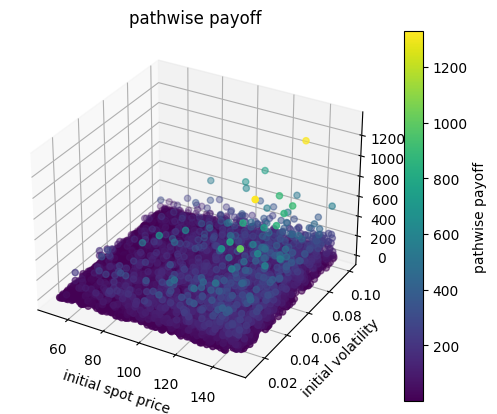

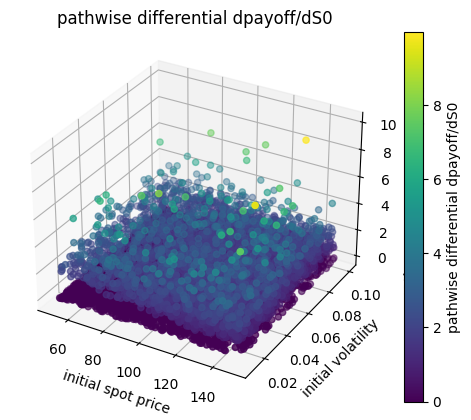

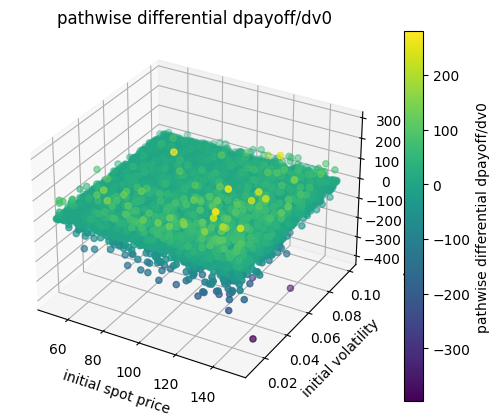

In [31]:

fig_payoff = plot_3d_differential_data(initial_spots, initial_vols, ps, "pathwise payoff")
fig_dS = plot_3d_differential_data(initial_spots, initial_vols, dps.S0, "pathwise differential dpayoff/dS0")
fig_dv = plot_3d_differential_data(initial_spots, initial_vols, dps.v0, "pathwise differential dpayoff/dv0")

In [148]:
class HestonTrainingSet(eqx.Module):
    initial_spots: Array
    initial_vols: Array
    payoffs: Array
    differentials: ModelState

class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

def training_set_precomputed(params: HestonParams, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range) -> HestonTrainingSet:

    def training_set_precomputed_inner(carry, key):
        n_inner_paths = 2**15
        key, key_spots, key_vols = jrandom.split(key, 3)
        initial_spots = jrandom.uniform(key_spots, shape=(n_inner_paths,), minval=spot_range.minval, maxval=spot_range.maxval)
        initial_vols = jrandom.uniform(key_vols, shape=(n_inner_paths,), minval=vol_range.minval, maxval=vol_range.maxval)
    
        # initial_spots = jnp.ones(n_inner_paths) * 100.0
        # initial_vols = jnp.ones(n_inner_paths) * 0.09    
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
        
        return carry, HestonTrainingSet(initial_spots, initial_vols, ps, dps)
    
    # due to limited vram of gpu we need to split up the computation into outer and inner paths.
    n_outer_paths = 2**6
    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, dataset = jax.lax.scan(training_set_precomputed_inner, None, key_rngs)
    return dataset

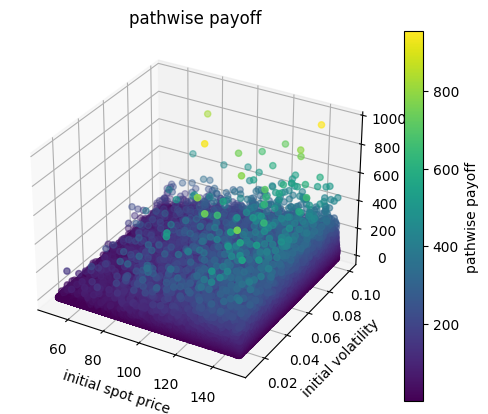

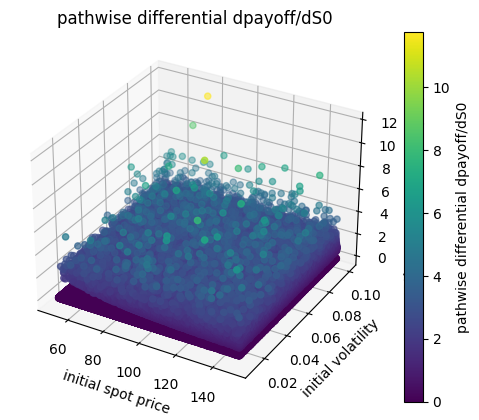

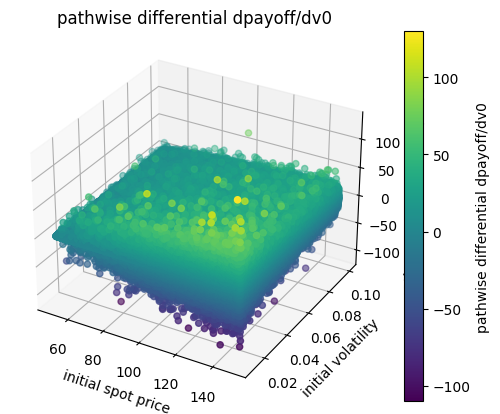

In [149]:
key = jrandom.PRNGKey(0)

# TODO: should this be part of the HestonParams class?
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

ds = training_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)

fig_payoff = plot_3d_differential_data(ds.initial_spots, ds.initial_vols, ds.payoffs, "pathwise payoff")
fig_dS = plot_3d_differential_data(ds.initial_spots, ds.initial_vols, ds.differentials.S0, "pathwise differential dpayoff/dS0")
fig_dv = plot_3d_differential_data(ds.initial_spots, ds.initial_vols, ds.differentials.v0, "pathwise differential dpayoff/dv0")


In [332]:
class HestonTestSet(eqx.Module):
    initial_spots: Array
    initial_vols: Array
    prices: Array
    greeks: ModelState

@eqx.filter_jit
def test_set_precomputed(params: HestonParams, *, key: PRNGKeyArray, spot_range: Range, vol_range: Range) -> HestonTestSet:

    def test_set_precomputed_inner(carry, key):
        n_inner_paths = 2**15
        key, key_spots, key_vols = jrandom.split(key, 3)

        # inisde the inner loop of the test set we always use the same initial state to determine the price afterwards.
        initial_spots = jnp.ones(n_inner_paths) * jrandom.uniform(key_spots, shape=(1,), minval=spot_range.minval, maxval=spot_range.maxval)
        initial_vols = jnp.ones(n_inner_paths) * jrandom.uniform(key_vols, shape=(1,), minval=vol_range.minval, maxval=vol_range.maxval)
        # jax.debug.print("initial spots {}", initial_spots)
        
        hs = Heston.from_parameters(params, S0=initial_spots, v0=initial_vols)
        
        path_seeds = jrandom.split(key, n_inner_paths)
        ps, dps = eqx.filter_vmap(partial(differential_path, n_time_steps=1024))(hs, path_seeds)
        
        return carry, HestonTrainingSet(initial_spots, initial_vols, ps, dps)
    
    # due to limited vram of gpu we need to split up the computation into outer and inner paths.
    n_outer_paths = 2**10
    key, subkey = jrandom.split(key)
    key_rngs = jrandom.split(subkey, n_outer_paths)
    carry, ds = jax.lax.scan(test_set_precomputed_inner, None, key_rngs)

    # jax.debug.print("ds payoffs {}", ds.payoffs.shape)
    # jax.debug.print("ds payoffs {}", ds.payoffs)

    def discounted_avg(x, h: Heston.Parameters):
        return jnp.mean(x, axis=1) * jnp.exp(-h.r * h.T) 
    
    test_set = HestonTestSet(*astuple(jax.tree_util.tree_map(partial(discounted_avg, h=hs_params), ds)))

    # jax.debug.print("test set {}", test_set)
    
    return test_set

# option_price = jnp.mean(payoffs) * jnp.exp(-hs.r * hs.T) # 9.774
# delta = jnp.mean(differentials.S0) * jnp.exp(-hs.r * hs.T) # 0.608
# dv = jnp.mean(differentials.v0) * jnp.exp(-hs.r * hs.T) # 39.495

# print("option_price: ", option_price)
# print("delta :", delta)
# print("dv0 :", dv)

In [ ]:
key = jrandom.PRNGKey(0)

# TODO: should this be part of the HestonParams class?
spot_range = Range(50.0, 150.0)
vol_range = Range(0.01, 0.1)

hs_params = Heston.Parameters(
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

test_set = test_set_precomputed(params=hs_params, key=key, spot_range=spot_range, vol_range=vol_range)


In [329]:
test_set.prices

Array([2.82231128e+01, 1.07744248e+00, 2.67220998e+01, 3.04982388e-01,
       7.46302950e-01, 1.14778023e+00, 4.29133850e+01, 1.87500000e-04,
       1.28409489e-01, 4.09347326e+00, 4.24349694e+01, 7.99519755e-01,
       2.10779588e+00, 1.89156279e+01, 1.47619147e+00, 2.05982727e+01,
       6.92212755e-02, 8.54609119e+00, 3.06125889e+01, 4.09214348e+00,
       2.53870310e+01, 2.88845508e+01, 3.99947964e+00, 1.87500000e-04,
       7.10567155e+00, 1.09289671e+01, 1.53130117e+01, 3.20736695e+01,
       3.28818160e-01, 8.06917778e+00, 1.11323294e+01, 2.99578409e+00,
       1.07717526e-01, 2.77014398e+00, 5.89819545e+01, 3.47642581e+00,
       4.36670073e+01, 1.87500000e-04, 4.28816582e+01, 2.21351546e-01,
       2.34057966e+01, 1.36957045e+00, 7.35124789e-01, 2.62375601e+01,
       1.01579315e+01, 3.76515117e+01, 1.27473919e+01, 1.88372395e+00,
       3.13352876e+00, 1.12723058e+00, 3.73928619e+01, 8.68192719e+00,
       2.05406969e+01, 1.01136587e+01, 1.98805427e+00, 2.64496484e+01,
      

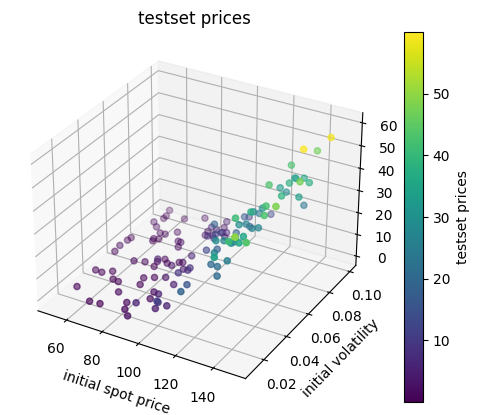

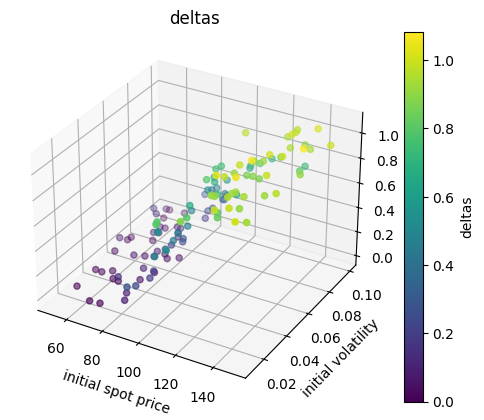

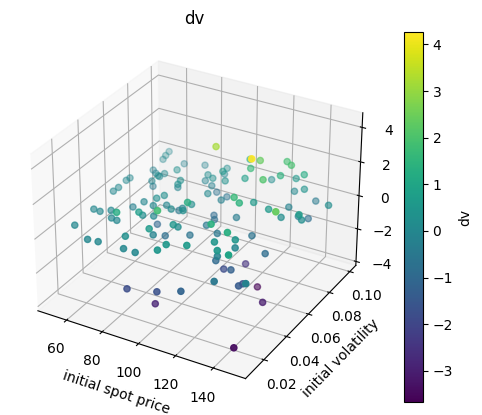

In [330]:

fig_payoff = plot_3d_differential_data(test_set.initial_spots, test_set.initial_vols, test_set.prices, "testset prices")
fig_dS = plot_3d_differential_data(test_set.initial_spots, test_set.initial_vols, test_set.greeks[0], "deltas")
fig_dS = plot_3d_differential_data(test_set.initial_spots, test_set.initial_vols, test_set.greeks[1], "dv")

In [249]:
test_set.initial_spots[44]

Array(102.77099263, dtype=float64)

In [250]:
test_set.initial_vols[44]

Array(0.09554092, dtype=float64)

In [255]:
test_set.prices[44]

Array(0.06895107, dtype=float64)

In [259]:
test_set.greeks[0]

Array([0.92761258, 0.84732642, 0.93437918, 0.91177911, 0.34374528,
       0.9460002 , 0.01212252, 0.23275534, 0.01007877, 0.01420872,
       0.85954999, 0.07867717, 0.08698317, 0.41583917, 0.88586124,
       0.76361345, 0.04188644, 0.92138153, 0.76624658, 0.78887055,
       0.93448912, 0.10325965, 0.78701678, 0.94571266, 0.03891178,
       0.89594213, 0.6008495 , 0.4415404 , 0.2476259 , 0.88330497,
       0.92164789, 0.95798679, 0.91390201, 0.01341488, 0.00843771,
       0.87664477, 0.91989589, 0.94880118, 0.1258078 , 0.6932424 ,
       0.7331767 , 0.94745092, 0.13273897, 0.06193372, 0.0055169 ,
       0.38342721, 0.06946626, 0.04879935, 0.29672518, 0.48293346,
       0.88515085, 0.0208709 , 0.01061748, 0.20544084, 0.95107617,
       0.05906519, 0.61830263, 0.02237155, 0.03656651, 0.94034066,
       0.79817478, 0.64567848, 0.65182328, 0.061722  , 0.79870442,
       0.42454778, 0.93245308, 0.77876278, 0.94443039, 0.19924987,
       0.86592419, 0.69384087, 0.77943629, 0.07411411, 0.51015